In [1]:
# Import Libraries
from common.Libraries import *
# Global Config
from common.GlobalConfig import *
# Utils
from common.Utils import *
# Model
from models.CNN import cnn

# Create folder if not exist
if not os.path.exists('./best_model'):
    os.makedirs('best_model')
# To show wider screen for output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

device = torch.device("cuda")

max_cnn_acc = 0.5733
max_random_acc = 0.5733
max_bay_acc = 0.5711

# 1. Helper Function

In [2]:
def train_cnn(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_cnn_layers, stride=1, kernel_index=0, sigmoid=0, num_of_epochs=5, verbose=False, plot=False, verbose_itr=False, method='bay'):
    # Build Model
    kernel_size = kernel_sizes_map[int(kernel_index)-1]
    if sigmoid > 0.5:
        sigmoid = True
    else:
        sigmoid = False
#     print(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_cnn_layers, kernel_index)
    if not check_valid_cnn_output_size(init_size=max_length, n_layers=int(num_cnn_layers), kernel_sizes=kernel_size, pool_size=int(pool_size), stride=int(stride)):
        return 0
    model = cnn(input_length=max_length, vocab_size=vocab_size, hidden_size=int(hidden_size), kernel_sizes=kernel_size,
                     dropout_rate=dropout_rate, num_filters=int(num_filters), num_mlp_layers=int(num_mlp_layers), output_size=output_size,
                     num_cnn_layers=int(num_cnn_layers), pool_size=int(pool_size), stride=int(stride), sigmoid=sigmoid)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    criterion = get_loss_function('BCE')
    model.to(device)
    total_train_acc=[]
    total_valid_acc=[]
    global max_cnn_acc
    global max_random_acc
    global max_bay_acc
    model.train()
    for e in range(int(num_of_epochs)):    
        if verbose_itr:
            print('Epoch', e+1, flush=True)
        train_acc = 0
        train_count = 0
        train_loss = 0
        train_acc_list = []
        with tqdm.tqdm(train_loader, disable=verbose==False) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                optimizer.zero_grad()
                logits = model(x_)
                loss, cor_count = criterion(logits, y_)
                loss.backward()
                train_acc += cor_count
                train_count += y.size(0)
                train_loss += loss.item() 
                optimizer.step()
                t.set_postfix({'Train loss': train_loss/train_count, 'Train acc': train_acc/train_count})
            total_train_acc.append(train_acc/train_count)
    model.eval()
    valid_acc = 0
    valid_count = 0
    valid_loss = 0
    with tqdm.tqdm(test_loader, disable=verbose==False) as t:
        for x, y in t:
            x_ = x.to(device)
            y_ = y.to(device)
            logits = model(x_)
            loss, cor_count = criterion(logits, y_)
            valid_acc += cor_count
            valid_count += y.size(0)
            valid_loss += loss.item()
            t.set_postfix({'Valid loss': valid_loss/valid_count, 'Valid acc': valid_acc/valid_count})
        total_valid_acc.append(valid_acc/valid_count)
    max_val_acc = valid_acc/valid_count
    if method == 'random':
        if max_val_acc > max_random_acc:
            save_model(model, f'best_cnn_model_random_{raw_data_size}')
            max_random_acc = max_val_acc
    else:
        if max_val_acc > max_bay_acc:
            save_model(model, f'best_cnn_model_bay_{raw_data_size}')
            max_bay_acc = max_val_acc
    
    if max_val_acc > max_cnn_acc:
        save_model(model, f'best_cnn_model_{raw_data_size}')
        max_cnn_acc = max_val_acc
    if plot:
        t = plt.plot(range(1, epochs + 1), total_train_acc, c='blue')[0]
        v = plt.plot(range(1, epochs + 1), total_valid_acc, c='green')[0]
        plt.legend([t, v], ['Train accuracy', 'Validation accuracy'])
        plt.xlabel('Epochs')
        plt.ylim(0.4, 0.8)
        plt.xticks(range(1, epochs + 1))
        plt.show()
    return max_val_acc
def get_trained_model(hidden_size, dropout_rate, learning_rate, l2_reg, num_filters, pool_size, num_mlp_layers, num_cnn_layers, stride=1, kernel_index=0, sigmoid=0, num_of_epochs=5):
    # Build Model
    kernel_size = kernel_sizes_map[int(kernel_index)-1]
    if sigmoid > 0.5:
        sigmoid = True
    else:
        sigmoid = False
    model = cnn(input_length=max_length, vocab_size=vocab_size, hidden_size=int(hidden_size), kernel_sizes=kernel_size,
                     dropout_rate=dropout_rate, num_filters=int(num_filters), num_mlp_layers=int(num_mlp_layers), output_size=output_size,
                     num_cnn_layers=int(num_cnn_layers), pool_size=int(pool_size), stride=int(stride), sigmoid=sigmoid)
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_reg)
    criterion = get_loss_function('BCE')
    model.to(device)
    max_val_acc = 0
    for e in range(int(num_of_epochs)):
        model.train()
        with tqdm.tqdm(train_loader, disable=True) as t:
            for x, y in t:
                x_ = x.to(device)
                y_ = y.to(device)
                optimizer.zero_grad()
                logits = model(x_)
                loss, _ = criterion(logits, y_)
                loss.backward()
                optimizer.step()
    return model

# 2. Load Data

In [3]:
train_X = np.load(f'{preprocessed_folder_path}/train_X.npy', allow_pickle=True)
train_Y = np.load(f'{preprocessed_folder_path}/train_Y.npy', allow_pickle=True)
test_X = np.load(f'{preprocessed_folder_path}/test_X.npy', allow_pickle=True)
test_Y = np.load(f'{preprocessed_folder_path}/test_Y.npy', allow_pickle=True)
output_size = train_Y.shape[1]
tag_to_index = pd.read_csv(f'{preprocessed_folder_path}/tag_to_index.csv', index_col='tag')
index_to_tag = pd.read_csv(f'{preprocessed_folder_path}/index_to_tag.csv')
cat_to_index = pd.read_csv(f'{preprocessed_folder_path}/cat_to_index.csv', index_col='cat')
index_to_cat = pd.read_csv(f'{preprocessed_folder_path}/index_to_cat.csv')
tag_to_cat = pd.read_csv(f'{preprocessed_folder_path}/tag_to_cat.csv', index_col='tag')

print(f"Train set shape: {train_X.shape}")
print(f"Test set shape: {test_X.shape}")

Train set shape: (10800, 250, 300)
Test set shape: (2700, 250, 300)


In [4]:
train_loader = DataLoader(MyDataset(train_X, train_Y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(MyDataset(test_X, test_Y), batch_size=batch_size)

# 3. Hyperparameter Tuning

## 3.1 Random Search

In [5]:
random_param_grid = {
    'hidden_size': [i for i in range(param_grid['hidden_size'][0], param_grid['hidden_size'][1]+1)],
    'dropout_rate': [i for i in np.arange(param_grid['dropout_rate'][0], param_grid['dropout_rate'][1]+0.1, 0.1)], 
    'learning_rate': [i for i in np.arange(param_grid['learning_rate'][0], param_grid['learning_rate'][1]+0.001, 0.001)], 
    'l2_reg': [i for i in np.arange(param_grid['l2_reg'][0], param_grid['l2_reg'][1]+0.0001, 0.0001)],
    'num_filters': [i for i in range(param_grid['num_filters'][0], param_grid['num_filters'][1]+1)],
    'pool_size': [i for i in range (param_grid['pool_size'][0], param_grid['pool_size'][1]+1)],
    'num_mlp_layers': [i for i in range(param_grid['num_mlp_layers'][0], param_grid['num_mlp_layers'][1]+1)],
    'num_cnn_layers': [i for i in range(param_grid['num_cnn_layers'][0], param_grid['num_cnn_layers'][1]+1)],
    'kernel_index': [i for i in range(param_grid['kernel_index'][0], param_grid['kernel_index'][1]+1)],
    'num_of_epochs': [i for i in range(param_grid['num_of_epochs'][0], param_grid['num_of_epochs'][1]+1)],
    'sigmoid': [i for i in range(param_grid['sigmoid'][0], param_grid['sigmoid'][1]+1)]
}
def random_search(n=10):
    best_accuracy = 0 
    best_params = {}
    tried_combinations = set()
    for i in range(n):
        print(f"Random Searching...{i+1}/{n}", flush=True)
        # Randomly get a combination
        train_param = {}
        while str(train_param) == '{}' or str(train_param) in tried_combinations:
            for param in random_param_grid:
                train_param[param] = random.choice(param_grid[param])
        train_accuracy = train_cnn(**train_param, verbose=100, method='random')
        if train_accuracy > best_accuracy:
            best_accuracy = train_accuracy
            best_params = train_param
        tried_combinations.add(str(train_param))
    return best_params

In [8]:
random_time_start = time.time()
best_random_params = random_search(250)
random_time_end = time.time()
del random_param_grid
random_training_time = (random_time_end - random_time_start)/60

Random Searching...1/250


100%|██████████| 169/169 [00:01<00:00, 114.11it/s, Valid loss=0.00671, Valid acc=0.0222]


Random Searching...2/250


100%|██████████| 169/169 [00:00<00:00, 193.53it/s, Valid loss=0.0434, Valid acc=0.0226]


Random Searching...3/250
Random Searching...4/250


100%|██████████| 169/169 [00:00<00:00, 179.67it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...5/250



100%|██████████| 169/169 [00:00<00:00, 188.67it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...6/250



100%|██████████| 169/169 [00:00<00:00, 178.37it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...7/250



100%|██████████| 169/169 [00:00<00:00, 224.16it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...8/250



100%|██████████| 169/169 [00:00<00:00, 195.71it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...9/250



100%|██████████| 169/169 [00:00<00:00, 192.75it/s, Valid loss=0.0588, Valid acc=0.0219]

Random Searching...10/250


Random Searching...11/250


100%|██████████| 169/169 [00:00<00:00, 170.47it/s, Valid loss=18.1, Valid acc=0.0222]

Random Searching...12/250



100%|██████████| 169/169 [00:00<00:00, 178.17it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...13/250


Random Searching...14/250


100%|██████████| 169/169 [00:00<00:00, 193.09it/s, Valid loss=0.00587, Valid acc=0.126]


Random Searching...15/250


100%|██████████| 169/169 [00:00<00:00, 169.69it/s, Valid loss=0.00635, Valid acc=0.0756]

Random Searching...16/250



100%|██████████| 169/169 [00:00<00:00, 174.19it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...17/250


Random Searching...18/250


100%|██████████| 169/169 [00:00<00:00, 196.92it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...19/250
Random Searching...20/250



100%|██████████| 169/169 [00:00<00:00, 194.32it/s, Valid loss=0.00642, Valid acc=0.107]

Random Searching...21/250


Random Searching...22/250


100%|██████████| 169/169 [00:01<00:00, 103.83it/s, Valid loss=0.00679, Valid acc=0.0222]

Random Searching...23/250



100%|██████████| 169/169 [00:00<00:00, 192.57it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...24/250



100%|██████████| 169/169 [00:01<00:00, 163.53it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...25/250
Random Searching...26/250



100%|██████████| 169/169 [00:00<00:00, 193.89it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...27/250



100%|██████████| 169/169 [00:00<00:00, 169.10it/s, Valid loss=0.0434, Valid acc=0.0222]


Random Searching...28/250


100%|██████████| 169/169 [00:00<00:00, 190.18it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...29/250
Random Searching...30/250



100%|██████████| 169/169 [00:01<00:00, 165.05it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...31/250



100%|██████████| 169/169 [00:01<00:00, 106.04it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...32/250
Random Searching...33/250



100%|██████████| 169/169 [00:00<00:00, 195.04it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...34/250



100%|██████████| 169/169 [00:00<00:00, 169.71it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...35/250
Random Searching...36/250



100%|██████████| 169/169 [00:00<00:00, 172.13it/s, Valid loss=0.0045, Valid acc=0.432]


Random Searching...37/250
Random Searching...38/250


100%|██████████| 169/169 [00:00<00:00, 189.00it/s, Valid loss=0.0434, Valid acc=0.0211]

Random Searching...39/250



100%|██████████| 169/169 [00:00<00:00, 203.83it/s, Valid loss=0.0436, Valid acc=0.0222]

Random Searching...40/250



100%|██████████| 169/169 [00:00<00:00, 226.08it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...41/250



100%|██████████| 169/169 [00:00<00:00, 228.95it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...42/250



100%|██████████| 169/169 [00:00<00:00, 230.78it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...43/250



100%|██████████| 169/169 [00:00<00:00, 236.07it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...44/250



100%|██████████| 169/169 [00:00<00:00, 228.81it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...45/250


Random Searching...46/250


100%|██████████| 169/169 [00:00<00:00, 190.31it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...47/250



100%|██████████| 169/169 [00:01<00:00, 126.51it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...48/250



100%|██████████| 169/169 [00:00<00:00, 223.27it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...49/250



100%|██████████| 169/169 [00:00<00:00, 184.02it/s, Valid loss=0.00675, Valid acc=0.0222]


Random Searching...50/250


100%|██████████| 169/169 [00:00<00:00, 189.84it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...51/250



100%|██████████| 169/169 [00:00<00:00, 229.64it/s, Valid loss=0.00404, Valid acc=0.52]


Random Searching...52/250


100%|██████████| 169/169 [00:00<00:00, 229.49it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...53/250


Random Searching...54/250


100%|██████████| 169/169 [00:00<00:00, 227.84it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...55/250


Random Searching...56/250


100%|██████████| 169/169 [00:01<00:00, 122.43it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...57/250



100%|██████████| 169/169 [00:00<00:00, 218.69it/s, Valid loss=0.00684, Valid acc=0.0222]

Random Searching...58/250



100%|██████████| 169/169 [00:00<00:00, 192.71it/s, Valid loss=0.00488, Valid acc=0.347]

Random Searching...59/250
Random Searching...60/250



100%|██████████| 169/169 [00:00<00:00, 233.10it/s, Valid loss=0.00711, Valid acc=0.05]

Random Searching...61/250



100%|██████████| 169/169 [00:00<00:00, 217.45it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...62/250



100%|██████████| 169/169 [00:00<00:00, 226.52it/s, Valid loss=0.0434, Valid acc=0.0222]


Random Searching...63/250


100%|██████████| 169/169 [00:00<00:00, 224.23it/s, Valid loss=0.0063, Valid acc=0.0789]

Random Searching...64/250



100%|██████████| 169/169 [00:00<00:00, 223.59it/s, Valid loss=0.00384, Valid acc=0.571]


Random Searching...65/250


100%|██████████| 169/169 [00:00<00:00, 192.78it/s, Valid loss=0.0434, Valid acc=0.0207]

Random Searching...66/250


Random Searching...67/250


100%|██████████| 169/169 [00:00<00:00, 231.41it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...68/250



100%|██████████| 169/169 [00:00<00:00, 189.73it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...69/250
Random Searching...70/250



100%|██████████| 169/169 [00:00<00:00, 213.83it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...71/250
Random Searching...72/250


Random Searching...73/250


100%|██████████| 169/169 [00:00<00:00, 190.79it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...74/250


Random Searching...75/250


100%|██████████| 169/169 [00:00<00:00, 223.58it/s, Valid loss=0.00645, Valid acc=0.0626]

Random Searching...76/250



100%|██████████| 169/169 [00:00<00:00, 231.49it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...77/250


Random Searching...78/250


100%|██████████| 169/169 [00:01<00:00, 126.88it/s, Valid loss=0.00678, Valid acc=0.0222]

Random Searching...79/250



100%|██████████| 169/169 [00:00<00:00, 199.14it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...80/250



100%|██████████| 169/169 [00:00<00:00, 219.36it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...81/250


Random Searching...82/250


100%|██████████| 169/169 [00:01<00:00, 126.92it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...83/250



100%|██████████| 169/169 [00:00<00:00, 209.43it/s, Valid loss=0.00674, Valid acc=0.0437]

Random Searching...84/250



100%|██████████| 169/169 [00:01<00:00, 116.67it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...85/250



100%|██████████| 169/169 [00:00<00:00, 215.43it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...86/250



100%|██████████| 169/169 [00:00<00:00, 189.11it/s, Valid loss=0.00618, Valid acc=0.107]

Random Searching...87/250



100%|██████████| 169/169 [00:00<00:00, 224.08it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...88/250



100%|██████████| 169/169 [00:00<00:00, 225.08it/s, Valid loss=0.00607, Valid acc=0.13]

Random Searching...89/250



100%|██████████| 169/169 [00:00<00:00, 195.85it/s, Valid loss=0.0435, Valid acc=0.0222]

Random Searching...90/250



100%|██████████| 169/169 [00:00<00:00, 187.53it/s, Valid loss=0.00638, Valid acc=0.0681]


Random Searching...91/250
Random Searching...92/250


100%|██████████| 169/169 [00:00<00:00, 189.50it/s, Valid loss=0.00506, Valid acc=0.347]

Random Searching...93/250


Random Searching...94/250


100%|██████████| 169/169 [00:00<00:00, 221.07it/s, Valid loss=0.00674, Valid acc=0.0352]

Random Searching...95/250
Random Searching...96/250



100%|██████████| 169/169 [00:00<00:00, 196.25it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...97/250


Random Searching...98/250


100%|██████████| 169/169 [00:00<00:00, 192.03it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...99/250



100%|██████████| 169/169 [00:00<00:00, 224.76it/s, Valid loss=0.00394, Valid acc=0.541]

Random Searching...100/250



100%|██████████| 169/169 [00:00<00:00, 182.45it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...101/250



100%|██████████| 169/169 [00:00<00:00, 227.80it/s, Valid loss=0.00629, Valid acc=0.0837]

Random Searching...102/250



100%|██████████| 169/169 [00:00<00:00, 219.74it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...103/250



100%|██████████| 169/169 [00:01<00:00, 124.06it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...104/250


Random Searching...105/250
Random Searching...106/250
Random Searching...107/250


100%|██████████| 169/169 [00:00<00:00, 223.31it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...108/250



100%|██████████| 169/169 [00:00<00:00, 221.62it/s, Valid loss=0.00684, Valid acc=0.0222]

Random Searching...109/250


Random Searching...110/250


100%|██████████| 169/169 [00:00<00:00, 217.44it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...111/250



100%|██████████| 169/169 [00:00<00:00, 190.46it/s, Valid loss=0.0065, Valid acc=0.0681]

Random Searching...112/250
Random Searching...113/250



100%|██████████| 169/169 [00:00<00:00, 193.05it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...114/250
Random Searching...115/250
Random Searching...116/250



100%|██████████| 169/169 [00:00<00:00, 190.96it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...117/250


Random Searching...118/250
Random Searching...119/250


100%|██████████| 169/169 [00:00<00:00, 220.80it/s, Valid loss=0.0381, Valid acc=0.03]

Random Searching...120/250



100%|██████████| 169/169 [00:00<00:00, 188.15it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...121/250



100%|██████████| 169/169 [00:00<00:00, 195.11it/s, Valid loss=0.0434, Valid acc=0.0222]


Random Searching...122/250
Random Searching...123/250
Random Searching...124/250


100%|██████████| 169/169 [00:00<00:00, 187.13it/s, Valid loss=0.00445, Valid acc=0.413]

Random Searching...125/250



100%|██████████| 169/169 [00:01<00:00, 113.17it/s, Valid loss=0.0434, Valid acc=0.0219]

Random Searching...126/250



100%|██████████| 169/169 [00:00<00:00, 175.55it/s, Valid loss=0.0434, Valid acc=0.0259]

Random Searching...127/250



100%|██████████| 169/169 [00:00<00:00, 180.57it/s, Valid loss=0.00676, Valid acc=0.0222]

Random Searching...128/250
Random Searching...129/250



100%|██████████| 169/169 [00:00<00:00, 170.48it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...130/250
Random Searching...131/250
Random Searching...132/250



100%|██████████| 169/169 [00:01<00:00, 116.96it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...133/250



100%|██████████| 169/169 [00:01<00:00, 111.11it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...134/250



100%|██████████| 169/169 [00:00<00:00, 178.25it/s, Valid loss=0.0434, Valid acc=0.0256]

Random Searching...135/250



100%|██████████| 169/169 [00:00<00:00, 179.84it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...136/250



100%|██████████| 169/169 [00:00<00:00, 187.68it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...137/250


Random Searching...138/250


100%|██████████| 169/169 [00:00<00:00, 180.62it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...139/250



100%|██████████| 169/169 [00:00<00:00, 175.43it/s, Valid loss=0.0434, Valid acc=0.0263]

Random Searching...140/250


Random Searching...141/250
Random Searching...142/250
Random Searching...143/250


100%|██████████| 169/169 [00:00<00:00, 215.29it/s, Valid loss=0.00644, Valid acc=0.0633]

Random Searching...144/250



100%|██████████| 169/169 [00:00<00:00, 178.07it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...145/250



100%|██████████| 169/169 [00:00<00:00, 200.95it/s, Valid loss=0.00621, Valid acc=0.0667]

Random Searching...146/250



100%|██████████| 169/169 [00:00<00:00, 180.88it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...147/250



100%|██████████| 169/169 [00:01<00:00, 165.95it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...148/250



100%|██████████| 169/169 [00:00<00:00, 177.32it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...149/250



100%|██████████| 169/169 [00:00<00:00, 174.87it/s, Valid loss=0.0434, Valid acc=0.0252]

Random Searching...150/250



100%|██████████| 169/169 [00:00<00:00, 200.94it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...151/250
Random Searching...152/250



100%|██████████| 169/169 [00:00<00:00, 203.95it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...153/250



100%|██████████| 169/169 [00:01<00:00, 101.11it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...154/250



100%|██████████| 169/169 [00:00<00:00, 174.96it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...155/250



100%|██████████| 169/169 [00:00<00:00, 181.27it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...156/250


Random Searching...157/250
Random Searching...158/250


100%|██████████| 169/169 [00:00<00:00, 174.25it/s, Valid loss=0.0051, Valid acc=0.283]

Random Searching...159/250



100%|██████████| 169/169 [00:00<00:00, 176.34it/s, Valid loss=0.00383, Valid acc=0.569]

Random Searching...160/250



100%|██████████| 169/169 [00:00<00:00, 202.87it/s, Valid loss=0.00676, Valid acc=0.0222]

Random Searching...161/250



100%|██████████| 169/169 [00:00<00:00, 174.22it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...162/250


Random Searching...163/250


100%|██████████| 169/169 [00:00<00:00, 179.97it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...164/250



100%|██████████| 169/169 [00:00<00:00, 177.59it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...165/250



100%|██████████| 169/169 [00:00<00:00, 214.47it/s, Valid loss=0.0434, Valid acc=0.0237]

Random Searching...166/250



100%|██████████| 169/169 [00:00<00:00, 171.81it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...167/250


Random Searching...168/250


100%|██████████| 169/169 [00:00<00:00, 176.34it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...169/250



100%|██████████| 169/169 [00:01<00:00, 117.11it/s, Valid loss=0.00703, Valid acc=0.0222]

Random Searching...170/250



100%|██████████| 169/169 [00:00<00:00, 210.97it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...171/250
Random Searching...172/250



100%|██████████| 169/169 [00:01<00:00, 109.28it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...173/250



100%|██████████| 169/169 [00:00<00:00, 209.05it/s, Valid loss=0.00645, Valid acc=0.0585]

Random Searching...174/250



100%|██████████| 169/169 [00:01<00:00, 162.42it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...175/250



100%|██████████| 169/169 [00:00<00:00, 203.91it/s, Valid loss=0.00623, Valid acc=0.0593]

Random Searching...176/250



100%|██████████| 169/169 [00:00<00:00, 187.90it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...177/250



100%|██████████| 169/169 [00:00<00:00, 201.67it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...178/250
Random Searching...179/250



100%|██████████| 169/169 [00:01<00:00, 162.05it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...180/250


Random Searching...181/250


100%|██████████| 169/169 [00:01<00:00, 162.60it/s, Valid loss=0.0434, Valid acc=0.0244]

Random Searching...182/250



100%|██████████| 169/169 [00:01<00:00, 160.04it/s, Valid loss=0.00675, Valid acc=0.0222]

Random Searching...183/250



100%|██████████| 169/169 [00:00<00:00, 178.86it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...184/250



100%|██████████| 169/169 [00:01<00:00, 95.31it/s, Valid loss=0.00686, Valid acc=0.0222]

Random Searching...185/250



100%|██████████| 169/169 [00:00<00:00, 175.46it/s, Valid loss=0.0063, Valid acc=0.07]

Random Searching...186/250


Random Searching...187/250


100%|██████████| 169/169 [00:00<00:00, 182.74it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...188/250



100%|██████████| 169/169 [00:01<00:00, 157.48it/s, Valid loss=0.0434, Valid acc=0.0278]

Random Searching...189/250



100%|██████████| 169/169 [00:01<00:00, 147.62it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...190/250



100%|██████████| 169/169 [00:00<00:00, 182.28it/s, Valid loss=0.00601, Valid acc=0.118]

Random Searching...191/250



100%|██████████| 169/169 [00:01<00:00, 151.45it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...192/250



100%|██████████| 169/169 [00:00<00:00, 180.90it/s, Valid loss=0.00653, Valid acc=0.0581]

Random Searching...193/250



100%|██████████| 169/169 [00:00<00:00, 192.19it/s, Valid loss=0.00652, Valid acc=0.0515]

Random Searching...194/250



100%|██████████| 169/169 [00:01<00:00, 160.50it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...195/250



100%|██████████| 169/169 [00:00<00:00, 199.49it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...196/250



100%|██████████| 169/169 [00:01<00:00, 167.59it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...197/250



100%|██████████| 169/169 [00:01<00:00, 151.17it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...198/250



100%|██████████| 169/169 [00:00<00:00, 206.09it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...199/250



100%|██████████| 169/169 [00:01<00:00, 157.06it/s, Valid loss=0.0067, Valid acc=0.0222]


Random Searching...200/250
Random Searching...201/250


100%|██████████| 169/169 [00:01<00:00, 150.10it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...202/250



100%|██████████| 169/169 [00:01<00:00, 160.58it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...203/250



100%|██████████| 169/169 [00:01<00:00, 100.76it/s, Valid loss=0.00669, Valid acc=0.0222]

Random Searching...204/250



100%|██████████| 169/169 [00:01<00:00, 93.48it/s, Valid loss=0.00674, Valid acc=0.0222]

Random Searching...205/250



100%|██████████| 169/169 [00:01<00:00, 160.12it/s, Valid loss=0.00674, Valid acc=0.0222]

Random Searching...206/250



100%|██████████| 169/169 [00:00<00:00, 173.43it/s, Valid loss=0.00654, Valid acc=0.0874]

Random Searching...207/250



100%|██████████| 169/169 [00:01<00:00, 108.04it/s, Valid loss=0.00684, Valid acc=0.0222]

Random Searching...208/250



100%|██████████| 169/169 [00:01<00:00, 108.10it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...209/250



100%|██████████| 169/169 [00:01<00:00, 98.70it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...210/250



100%|██████████| 169/169 [00:01<00:00, 102.92it/s, Valid loss=0.045, Valid acc=0.0222]

Random Searching...211/250
Random Searching...212/250



100%|██████████| 169/169 [00:01<00:00, 114.44it/s, Valid loss=0.00683, Valid acc=0.0222]

Random Searching...213/250
Random Searching...214/250
Random Searching...215/250
Random Searching...216/250



100%|██████████| 169/169 [00:00<00:00, 203.64it/s, Valid loss=0.00376, Valid acc=0.573]


Random Searching...217/250
Random Searching...218/250


100%|██████████| 169/169 [00:01<00:00, 151.51it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...219/250



100%|██████████| 169/169 [00:00<00:00, 175.93it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...220/250



100%|██████████| 169/169 [00:01<00:00, 101.82it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...221/250



100%|██████████| 169/169 [00:01<00:00, 163.90it/s, Valid loss=0.0434, Valid acc=0.0237]

Random Searching...222/250



100%|██████████| 169/169 [00:00<00:00, 183.92it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...223/250



100%|██████████| 169/169 [00:01<00:00, 157.60it/s, Valid loss=0.0434, Valid acc=0.0207]

Random Searching...224/250



100%|██████████| 169/169 [00:00<00:00, 188.10it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...225/250



100%|██████████| 169/169 [00:01<00:00, 93.79it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...226/250



100%|██████████| 169/169 [00:00<00:00, 180.24it/s, Valid loss=0.00672, Valid acc=0.0222]

Random Searching...227/250



100%|██████████| 169/169 [00:01<00:00, 155.55it/s, Valid loss=0.00649, Valid acc=0.0963]

Random Searching...228/250
Random Searching...229/250



100%|██████████| 169/169 [00:01<00:00, 160.91it/s, Valid loss=0.00607, Valid acc=0.127]

Random Searching...230/250


Random Searching...231/250


100%|██████████| 169/169 [00:00<00:00, 178.26it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...232/250



100%|██████████| 169/169 [00:01<00:00, 97.08it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...233/250



100%|██████████| 169/169 [00:01<00:00, 98.87it/s, Valid loss=0.00671, Valid acc=0.0222]

Random Searching...234/250



100%|██████████| 169/169 [00:01<00:00, 160.38it/s, Valid loss=0.0442, Valid acc=0.0222]

Random Searching...235/250



100%|██████████| 169/169 [00:00<00:00, 188.61it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...236/250



100%|██████████| 169/169 [00:00<00:00, 169.89it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...237/250


Random Searching...238/250


100%|██████████| 169/169 [00:01<00:00, 160.31it/s, Valid loss=0.0434, Valid acc=0.02]


Random Searching...239/250
Random Searching...240/250


100%|██████████| 169/169 [00:00<00:00, 194.12it/s, Valid loss=0.0067, Valid acc=0.0222]

Random Searching...241/250



100%|██████████| 169/169 [00:01<00:00, 166.63it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...242/250
Random Searching...243/250



100%|██████████| 169/169 [00:00<00:00, 171.89it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...244/250



100%|██████████| 169/169 [00:01<00:00, 150.73it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...245/250



100%|██████████| 169/169 [00:01<00:00, 151.69it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...246/250



100%|██████████| 169/169 [00:01<00:00, 106.11it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...247/250



100%|██████████| 169/169 [00:01<00:00, 157.76it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...248/250
Random Searching...249/250



100%|██████████| 169/169 [00:01<00:00, 167.95it/s, Valid loss=0.0434, Valid acc=0.0222]

Random Searching...250/250



100%|██████████| 169/169 [00:01<00:00, 93.54it/s, Valid loss=0.0434, Valid acc=0.0222]


In [6]:
# best_random_params = {'dropout_rate': 0.5,
#   'hidden_size': 256,
#   'kernel_index': 1,
#   'l2_reg': 0.0001,
#   'learning_rate': 0.001,
#   'num_cnn_layers': 1,
#   'num_filters': 64,
#   'num_mlp_layers': 1,
#   'num_of_epochs': 25,
#   'pool_size': 2,
#   'sigmoid': 0}
# random_training_time = 339.04367617766064
best_random_params, random_training_time

({'dropout_rate': 0.5,
  'hidden_size': 256,
  'kernel_index': 1,
  'l2_reg': 0.0001,
  'learning_rate': 0.001,
  'num_cnn_layers': 1,
  'num_filters': 64,
  'num_mlp_layers': 1,
  'num_of_epochs': 25,
  'pool_size': 2,
  'sigmoid': 0},
 339.04367617766064)

In [7]:
best_random_model = load_model(f'best_cnn_model_random_{raw_data_size}')
y_true, y_random_pred, y_true_cat, y_random_pred_cat = predict(best_random_model, test_loader, index_to_tag, tag_to_cat)

# Tag accuracy
best_random_acc = accuracy_score(y_true, y_random_pred)
# Cat accuracy
best_random_cat_acc = accuracy_score(y_true_cat, y_random_pred_cat)

best_random_acc, best_random_cat_acc, best_random_params

100%|██████████| 169/169 [00:00<00:00, 664.30it/s]


(0.5733333333333334,
 0.7222222222222222,
 {'dropout_rate': 0.5,
  'hidden_size': 256,
  'kernel_index': 1,
  'l2_reg': 0.0001,
  'learning_rate': 0.001,
  'num_cnn_layers': 1,
  'num_filters': 64,
  'num_mlp_layers': 1,
  'num_of_epochs': 25,
  'pool_size': 2,
  'sigmoid': 0})

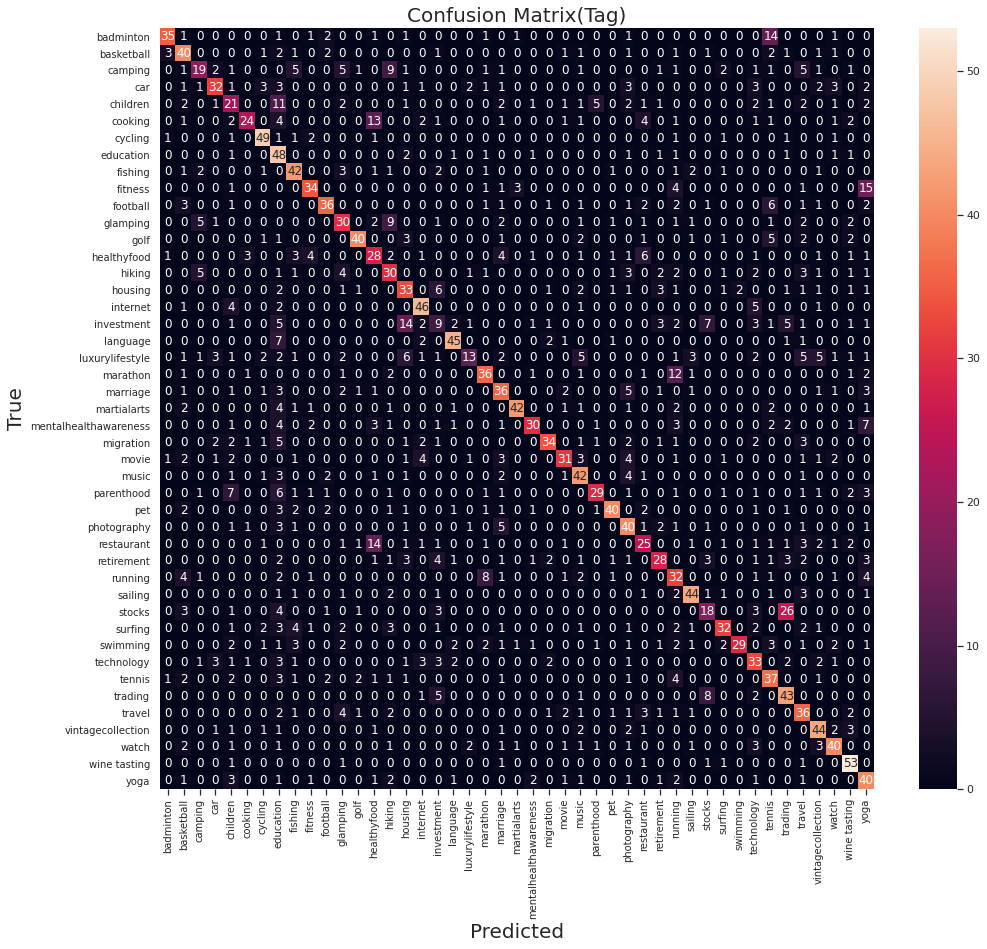

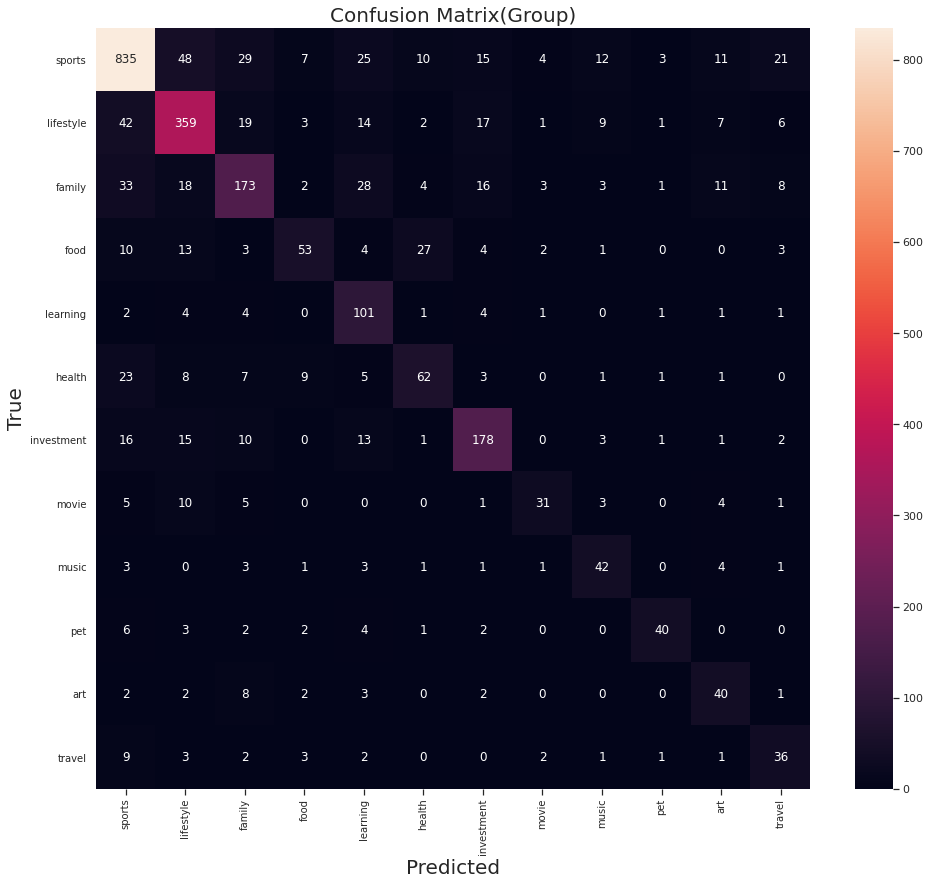

In [8]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_random_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_random_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [9]:
print_classification_report(y_random_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_random_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.83      0.58      0.69        60
           basketball       0.56      0.67      0.61        60
              camping       0.53      0.32      0.40        60
                  car       0.70      0.53      0.60        60
             children       0.33      0.35      0.34        60
              cooking       0.77      0.40      0.53        60
              cycling       0.75      0.82      0.78        60
            education       0.33      0.80      0.47        60
              fishing       0.59      0.70      0.64        60
              fitness       0.71      0.57      0.63        60
             football       0.75      0.60      0.67        60
             glamping       0.49      0.50      0.50        60
                 golf       0.83      0.67      0.74        60
          healthyfood       0.41      0.47      0.43        60
               hiking    

## 3.2 Bayesian Optimization

In [12]:
bayesian_time_start = time.time()
bayesian_param_grid = {
    'hidden_size': param_grid['hidden_size'],
    'dropout_rate': param_grid['dropout_rate'], 
    'learning_rate': param_grid['learning_rate'], 
    'l2_reg': param_grid['l2_reg'],
    'num_filters': param_grid['num_filters'],
    'pool_size': param_grid['pool_size'],
    'num_mlp_layers': param_grid['num_mlp_layers'],
    'num_cnn_layers': param_grid['num_cnn_layers'],
    'kernel_index': param_grid['kernel_index'],
    'num_of_epochs': param_grid['num_of_epochs'],
    'sigmoid': param_grid['sigmoid']
}
# Bounded region of parameter space
optimizer = BayesianOptimization(
    f=train_cnn,
    pbounds=bayesian_param_grid,
    verbose=2,  # verbose = 1 prints only when a maximum is obsenew_optimizerrved, verbose = 0 is silent
#     random_state=random_seed
)

optimizer.maximize(init_points=50, n_iter=200)

bayesian_time_end = time.time()
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

best_bay_params = optimizer.max['params']
bay_training_time = (bayesian_time_end - bayesian_time_start)/60

|   iter    |  target   | dropou... | hidden... | kernel... |  l2_reg   | learni... | num_cn... | num_fi... | num_ml... | num_of... | pool_size |  sigmoid  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.0      |  0.2598   |  250.0    |  10.78    |  0.000963 |  0.008963 |  4.639    |  8.178    |  3.828    |  5.371    |  59.93    |  0.5884   |
|  2        |  0.02222  |  0.1726   |  143.7    |  2.714    |  0.000690 |  0.002275 |  2.944    |  29.36    |  3.109    |  6.149    |  16.67    |  0.2715   |
|  3        |  0.02222  |  0.3359   |  98.18    |  4.798    |  0.000299 |  0.00715  |  2.226    |  3.754    |  1.68     |  8.924    |  49.85    |  0.4598   |
|  4        |  0.02222  |  0.2679   |  229.8    |  30.59    |  0.000975 |  0.00985  |  2.731    |  14.22    |  4.423    |  16.88    |  2.628    |  0.3775   |
|  5        |  0.02222  |  0.2834   |  188.4    |  2

In [10]:
# best_bay_params = {'dropout_rate': 0.10706247791959392,
#   'hidden_size': 24.18426344328656,
#   'kernel_index': 23.278582747781737,
#   'l2_reg': 0.00017946719800320782,
#   'learning_rate': 0.001217473334143848,
#   'num_cnn_layers': 1.0339667924593798,
#   'num_filters': 38.680021537830726,
#   'num_mlp_layers': 1.0,
#   'num_of_epochs': 11.389300991615341,
#   'pool_size': 29.377602182660834,
#   'sigmoid': 0.10083716985953027}
# bay_training_time = 160.12686095635095
best_bay_params, bay_training_time

({'dropout_rate': 0.10706247791959392,
  'hidden_size': 24.18426344328656,
  'kernel_index': 23.278582747781737,
  'l2_reg': 0.00017946719800320782,
  'learning_rate': 0.001217473334143848,
  'num_cnn_layers': 1.0339667924593798,
  'num_filters': 38.680021537830726,
  'num_mlp_layers': 1.0,
  'num_of_epochs': 11.389300991615341,
  'pool_size': 29.377602182660834,
  'sigmoid': 0.10083716985953027},
 160.12686095635095)

In [11]:
best_bay_model = load_model(f'best_cnn_model_bay_{raw_data_size}')
y_true, y_bay_pred, y_true_cat, y_bay_pred_cat = predict(best_bay_model, test_loader, index_to_tag, tag_to_cat)

# Tag accuracy
best_bay_acc = accuracy_score(y_true, y_bay_pred)
# Cat accuracy
best_bay_cat_acc = accuracy_score(y_true_cat, y_bay_pred_cat)

best_bay_acc, best_bay_cat_acc, best_bay_params

100%|██████████| 169/169 [00:00<00:00, 602.99it/s]


(0.5711111111111111,
 0.7125925925925926,
 {'dropout_rate': 0.10706247791959392,
  'hidden_size': 24.18426344328656,
  'kernel_index': 23.278582747781737,
  'l2_reg': 0.00017946719800320782,
  'learning_rate': 0.001217473334143848,
  'num_cnn_layers': 1.0339667924593798,
  'num_filters': 38.680021537830726,
  'num_mlp_layers': 1.0,
  'num_of_epochs': 11.389300991615341,
  'pool_size': 29.377602182660834,
  'sigmoid': 0.10083716985953027})

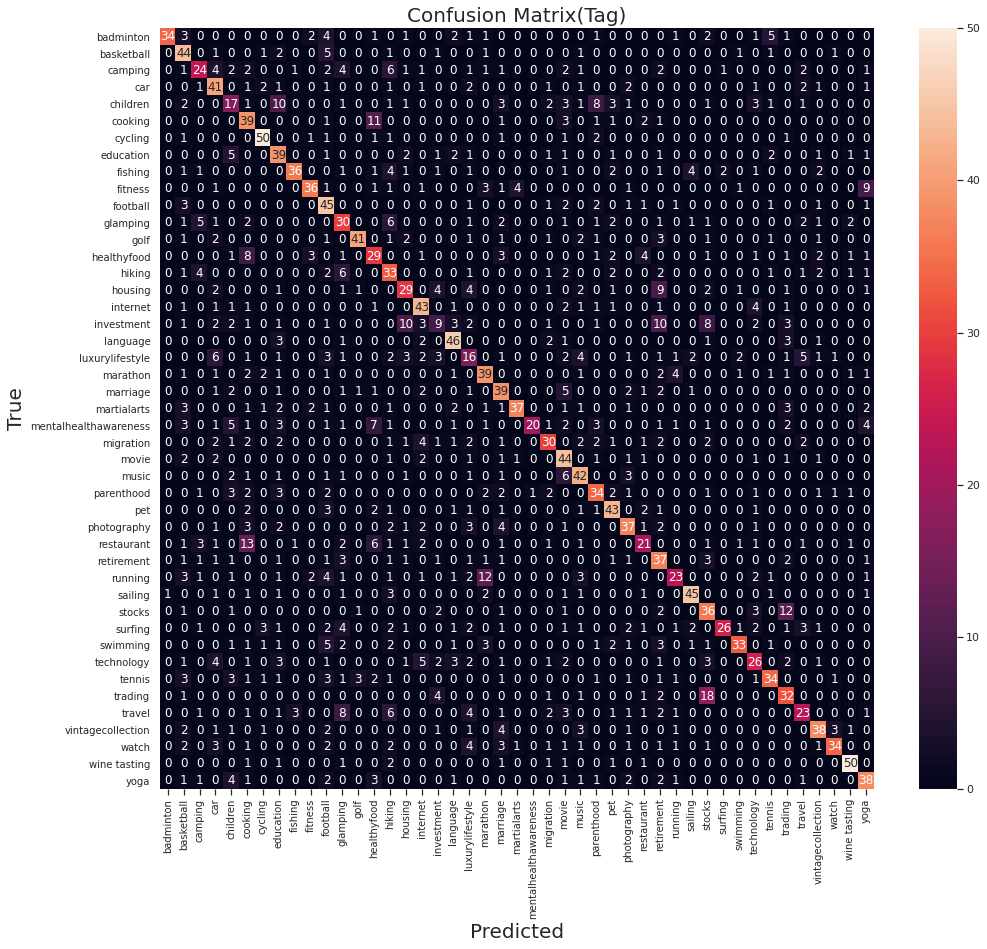

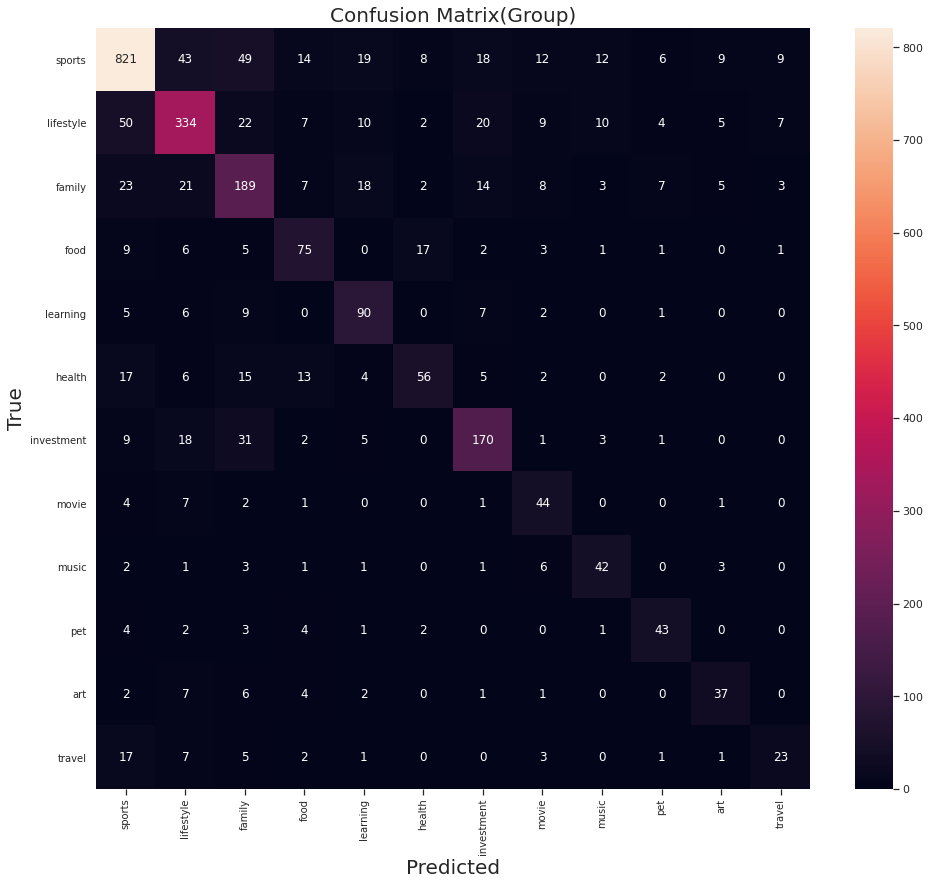

In [12]:
plot_confusion_matrix([index_to_tag['tag'][i] for i in y_bay_pred], [index_to_tag['tag'][i] for i in y_true], index_to_tag['tag'].tolist(), title='Confusion Matrix(Tag)')
plot_confusion_matrix(y_bay_pred_cat, y_true_cat, index_to_cat['cat'].tolist(), title='Confusion Matrix(Group)')

In [13]:
print_classification_report(y_bay_pred, y_true, index_to_tag['tag'].tolist(), title='Classification Report (Tag):')
print_classification_report([cat_to_index.loc[i][0] for i in y_bay_pred_cat], [cat_to_index.loc[i][0] for i in y_true_cat], index_to_cat['cat'].tolist(), title='Classification Report (Group):')

Classification Report (Tag):
                       precision    recall  f1-score   support

            badminton       0.97      0.57      0.72        60
           basketball       0.52      0.73      0.61        60
              camping       0.55      0.40      0.46        60
                  car       0.51      0.68      0.59        60
             children       0.32      0.28      0.30        60
              cooking       0.43      0.65      0.52        60
              cycling       0.81      0.83      0.82        60
            education       0.46      0.65      0.54        60
              fishing       0.88      0.60      0.71        60
              fitness       0.78      0.60      0.68        60
             football       0.45      0.75      0.57        60
             glamping       0.42      0.50      0.45        60
                 golf       0.87      0.68      0.77        60
          healthyfood       0.44      0.48      0.46        60
               hiking    

# 4. Result Summary

In [14]:
result = {
    'random_search': {
        'training_time(mins)': random_training_time,
        'accuracy': best_random_acc,
        'accuracy(group)': best_random_cat_acc,
        **get_clean_params(best_random_params)
    },
    'bayesian': {
        'training_time(mins)': bay_training_time,
        'accuracy': best_bay_acc,
        'accuracy(group)': best_bay_cat_acc,
        **get_clean_params(best_bay_params)
    },
}

In [15]:
result = pd.DataFrame.from_dict(result)
result

,random_search,bayesian
training_time(mins),5.650728,2.668781
accuracy,0.573333,0.571111
accuracy(group),0.722222,0.712593
dropout_rate,0.5,0.107062
hidden_size,256,24
l2_reg,0.0001,0.000179
learning_rate,0.001,0.001217
num_cnn_layers,1,1
num_filters,64,38
num_mlp_layers,1,1
